In [1]:
import json
import tensorflow as tf
import numpy as np
import urllib
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2023-08-15 11:09:09--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-08-15 11:09:09--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-08-15 11:09:10--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [3]:
!unzip glove*.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [4]:
embeddings_index = {}
with open('glove.6B.100d.txt') as f:
  for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word]=coefs

In [8]:
url = 'https://storage.googleapis.com/download.tensorflow.org/data/sarcasm.json'
urllib.request.urlretrieve(url, 'sarcasm.json')

('sarcasm.json', <http.client.HTTPMessage at 0x78f7013a8fd0>)

In [16]:
vocab_size = 1000
embedding_dim = 100
max_length = 120
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 20000

In [17]:
sentences = []
labels = []

In [18]:
with open("sarcasm.json", 'r') as f:
        datastore = json.load(f)

for item in datastore:
  sentences.append(item['headline'])
  labels.append(item['is_sarcastic'])

In [19]:
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [20]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

callbacks = [
EarlyStopping(
            monitor='val_accuracy',
            min_delta=1e-4,
            patience=3,
            verbose=1
        ),
ModelCheckpoint(
            filepath='mymodel.h5',
            monitor='val_accuracy',
            mode='max',
            save_best_only=True,
            save_weights_only=False,
            verbose=1
        )
]

    # Need this block to get it to work with TensorFlow 2.x
import numpy as np
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [26]:
embeddings_matrix = np.zeros((vocab_size, embedding_dim))
for key in sorted(word_index, key=word_index.get)[:vocab_size]:
    embedding_vector = embeddings_index.get(key)
    if embedding_vector is not None:
        embeddings_matrix[word_index[key]] = embedding_vector

In [27]:
embeddings_matrix.shape

(1000, 100)

In [28]:
for key in sorted(word_index, key=word_index.get)[:10]:
  print(key,end=' ')
  print(word_index.get(key))

<OOV> 1
to 2
of 3
the 4
in 5
for 6
a 7
on 8
and 9
with 10


In [31]:
model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length, weights=[embeddings_matrix]),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
        #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, return_sequences=True)),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1, activation='softmax')
    ])
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.SGD(learning_rate=1e-5), metrics=['accuracy'])

num_epochs = 10


In [60]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length, weights=[embeddings_matrix]),
    tf.keras.layers.Conv1D(8, 5, activation='relu'),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), metrics=['accuracy'])

num_epochs = 150

In [61]:
history = model.fit(training_padded, training_labels, epochs=num_epochs,validation_data=(testing_padded, testing_labels), verbose=1)

Epoch 1/150
625/625 [==============================] - 21s 26ms/step - loss: 0.6926 - accuracy: 0.5135 - val_loss: 0.6900 - val_accuracy: 0.5628
Epoch 2/150
625/625 [==============================] - 9s 14ms/step - loss: 0.6876 - accuracy: 0.5605 - val_loss: 0.6845 - val_accuracy: 0.5633
Epoch 3/150
625/625 [==============================] - 9s 14ms/step - loss: 0.6803 - accuracy: 0.5604 - val_loss: 0.6756 - val_accuracy: 0.5634
Epoch 4/150
625/625 [==============================] - 8s 13ms/step - loss: 0.6655 - accuracy: 0.5816 - val_loss: 0.6534 - val_accuracy: 0.6236
Epoch 5/150
625/625 [==============================] - 8s 13ms/step - loss: 0.6293 - accuracy: 0.6617 - val_loss: 0.6108 - val_accuracy: 0.6828
Epoch 6/150
625/625 [==============================] - 8s 13ms/step - loss: 0.5820 - accuracy: 0.7024 - val_loss: 0.5735 - val_accuracy: 0.7025
Epoch 7/150
625/625 [==============================] - 8s 13ms/step - loss: 0.5531 - accuracy: 0.7175 - val_loss: 0.5558 - val_accuracy

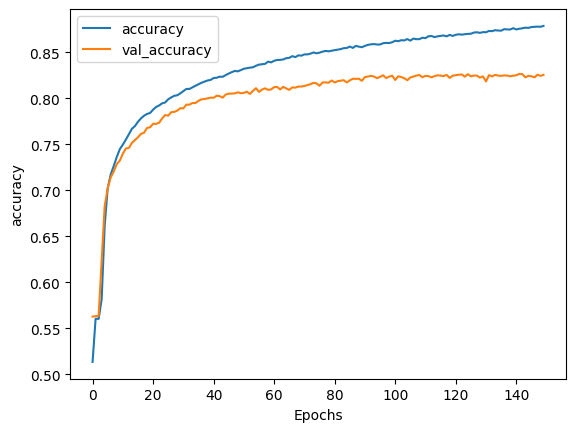

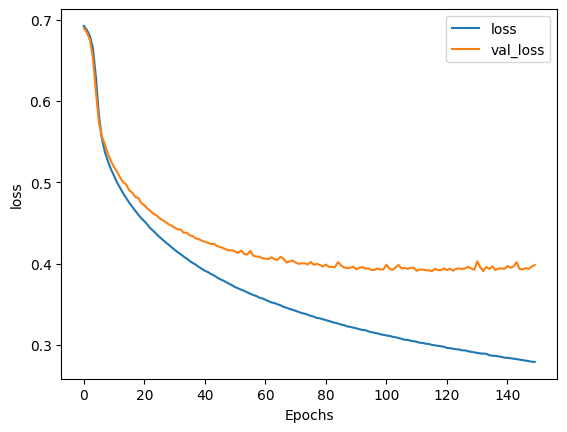

In [62]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [63]:
model.save("test.h5")